<a href="https://colab.research.google.com/github/nabarahim/AFIB-and-MI-Correlation/blob/main/ecg_classification_(Mitbh).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart beats classification problem
A typical task for applied Machine Learning in medicine is an automatic classification of signals from diagnostic devices such as ECG or EEG

Typical pipeline:
- detect QRS compexes (beats)
- classify them:
> - normal beat N
> - arrhytmia, e.g. *venticular* V, *supraventicular* S arrytmia, or *artial fibrillation* AF

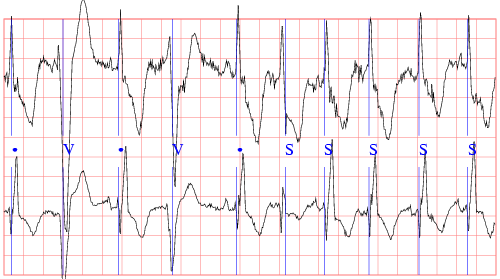

![ECG signal](https://ars.els-cdn.com/content/image/1-s2.0-S0950705120307188-gr1.jpg)

a couple of links:
- [exemplary challenge from Physionet](https://physionet.org/content/challenge-2017/1.0.0/)
- [some recent paper on ECG classification](https://doi.org/10.1016/j.knosys.2020.106589)

## our challenge: classify beats as normal or abnormal (arrhytmia)
- we will utilize signals from **svdb** database, and grab subsequent beats (data preprocessing)
- then construct binary classifier using NN, decision trees, ensemble metchods, and SVM or NaiveBayes

# Dataset preparation
1. Download ecg waves from **svdb** database provided by *PhysioNet*
2. Divide signals into samples, each containing single heartbeat (with window size of 96 points, *sampling ratio* = 128 points/s)
3. Take only samples annotated as 'N' (normal beat), or 'S' and 'V' (arrhythmias)

In [ ]:
import os
import numpy as np

# install PhysioNet ecg data package
!pip install wfdb
import wfdb

# list of available datasets
dbs = wfdb.get_dbs()
display(dbs)

# we choose svdb
svdb_dir = os.path.join(os.getcwd(), 'mitdb')
wfdb.dl_database('mitdb', dl_dir=svdb_dir)

# Display the  downloaded content
svdb_in_files = [os.path.splitext(f)[0] for f in os.listdir(svdb_dir) if f.endswith('.dat')]
print(svdb_in_files)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.1 MB/s eta 0:00:00


[['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['accelerometry-walk-climb-drive',
  'Labeled raw accelerometry data captured during walking, stair climbing and driving'],
 ['actes-cycloergometer-exercise',
  'Cardiorespiratory measurement from graded cycloergometer exercise testing'],
 ['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['afdb', 'MIT-BIH Atrial Fibrillation Database'],
 ['afpdb', 'PAF Prediction Challenge Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database Sample Excluded Record'],
 ['annotation-opioid-use-notes',
  'Annotation dataset of problematic opioid use and related contexts from MIMIC-III Critical Care Database discharge summaries'],
 ['antimicrobial-resistance-uti',
  'AMR-UTI: Antimicrobial Resistance in Urinary Tract Infections'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['auditory-eeg', 'Auditory evoked potential EEG-Biometric dataset'],
 ['autonomic-aging-cardiovascular',
  'Autonomic Aging: A dataset to quantify ch

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [ ]:
time_window = 48
all_beats = []
all_annotations = []
for in_file in svdb_in_files:
    print('...processing...' + in_file + '...file')
    signal, fields = wfdb.rdsamp(os.path.join(svdb_dir,in_file), channels=[0])
    annotations = wfdb.rdann(os.path.join(svdb_dir,in_file), 'atr')
    signal=np.array(signal).flatten()
    # grab subsequent heartbeats within [position-64,position+64] window
    beats = np.zeros((len(annotations.sample),time_window*2))
    # note that we remove first and last beats to ensure that all beats have equal lengths
    for i, ann_position in enumerate(annotations.sample[5:-5]):
        beats[i] = signal[ann_position-time_window:ann_position+time_window]
    all_beats.append(beats)
    # consequently, we remove few first and last annotations
    all_annotations.append(annotations.symbol[5:-5])

all_beats = np.concatenate(all_beats)
all_annotations = np.concatenate(all_annotations)

# check which annotations are usable for us, are of N or S or V class
indices = [i for i, ann in enumerate(all_annotations) if ann in {'N','S','V','F','Q'}]
# and get only these
all_beats = all_beats[indices]
all_annotations = np.array([all_annotations[i] for i in indices])

# print data statistics
print(all_beats.shape, all_annotations.shape)
print('no of N beats: ' + str(np.count_nonzero(all_annotations == 'N')))
print('no of S beats: ' + str(np.count_nonzero(all_annotations == 'S')))
print('no of V beats: ' + str(np.count_nonzero(all_annotations == 'V')))
print('no of F beats: ' + str(np.count_nonzero(all_annotations == 'F')))
print('no of Q beats: ' + str(np.count_nonzero(all_annotations == 'Q')))

...processing...122...file
...processing...109...file
...processing...115...file
...processing...108...file
...processing...228...file
...processing...212...file
...processing...106...file
...processing...116...file
...processing...233...file
...processing...210...file
...processing...222...file
...processing...101...file
...processing...207...file
...processing...217...file
...processing...118...file
...processing...112...file
...processing...114...file
...processing...103...file
...processing...124...file
...processing...200...file
...processing...113...file
...processing...121...file
...processing...104...file
...processing...221...file
...processing...105...file
...processing...223...file
...processing...215...file
...processing...209...file
...processing...213...file
...processing...203...file
...processing...230...file
...processing...111...file
...processing...201...file
...processing...117...file
...processing...100...file
...processing...107...file
...processing...232...file
.

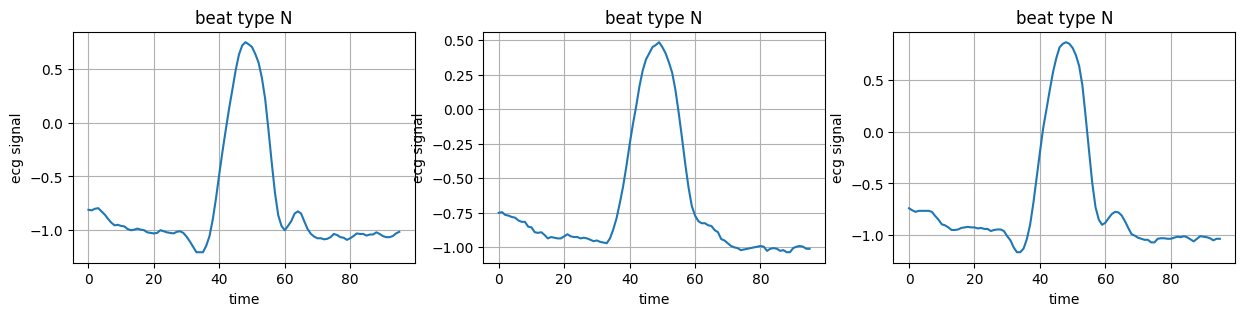

In [ ]:
# show example samples
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 3)
plt.subplots_adjust(wspace=0.2)
sample_number = [200,299,996]

for i, sn in enumerate(sample_number):
    ax[i].plot(all_beats[sn])
    ax[i].set(xlabel='time', ylabel='ecg signal', title='beat type ' + all_annotations[sn])
    ax[i].grid()
plt.show()

# Experiments

0. Preliminaries
> - Divide dataset into train/validation/test subset, and normalize each of them.
> - Define classification accuracy metrics (dataset is imbalanced)
>>Confusion matrix
```
____Prediction
T |   n  s  v
r |N  Nn Ns Nv
u |S  Sn Ss Sv
t |V  Vn Vs Vv
h |
```
>> - Total accuracy
$Acc_T = \frac{Nn+Ss+Vv}{\Sigma_N+\Sigma_S+\Sigma_V}$,
>> - Arrhythmia accuracy (S or V cases are more important to be detected):
$Acc_A = \frac{Ss+Vv}{\Sigma_S+\Sigma_V}$,
>> - $\Sigma_N=Nn+Ns+Nv$, $\Sigma_S=Sn+Ss+Sv$,
$\Sigma_V=Vn+Vs+Vv$

1. Standard classifiers: *naive Bayes* and *SVM*
2. Decision Tree with optimized max_depth
3. Random Forest with vector of features

In [ ]:
# prepare datasets and define error metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# to simplify experiments and speedup training
# we take only some part of the whole dataset
X, y = all_beats[::5], all_annotations[::5]

# train/validation/test set splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15/0.85, random_state=0)
print(len(y_train), len(y_val), len(y_test))

# perform data normalization: z = (x - u)/s
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
# same for the validation subset
X_val = preprocessing.StandardScaler().fit_transform(X_val)
# and for the test subset
X_test = preprocessing.StandardScaler().fit_transform(X_test)

# define accuracy
def calculate_accuracy(y_pred, y_gt, comment='', printout=True):
    acc_t = np.count_nonzero(y_pred == y_gt)/len(y_gt)
    acc_a = np.count_nonzero(
        np.logical_and(y_pred == y_gt, y_gt != 'N'))/np.count_nonzero(y_gt != 'N')
    if printout is True:
        print('-----------------------------------')
        print(comment)
        print('Total accuracy, Acc_T = {:.4f}'.format(acc_t))
        print('Arrhythmia accuracy, Acc_A = {:.4f}'.format(acc_a))
        print('-----------------------------------')
    else: return acc_t, acc_a

9126 1956 5459


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='naive Bayes classifier')

svc = svm.SVC()
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='SVM classifier')

svc = svm.SVC(class_weight='balanced')
y_pred = svc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced SVM classifier')

-----------------------------------
naive Bayes classifier
Total accuracy, Acc_T = 0.5312
Arrhythmia accuracy, Acc_A = 0.4008
-----------------------------------
-----------------------------------
SVM classifier
Total accuracy, Acc_T = 0.9102
Arrhythmia accuracy, Acc_A = 0.0081
-----------------------------------
-----------------------------------
balanced SVM classifier
Total accuracy, Acc_T = 0.6153
Arrhythmia accuracy, Acc_A = 0.6923
-----------------------------------


In [ ]:
y_pred = gnb.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           F       0.03      0.59      0.05        49
           N       0.95      0.54      0.69      4965
           Q       0.00      0.00      0.00         1
           V       0.11      0.38      0.17       444

    accuracy                           0.53      5459
   macro avg       0.27      0.38      0.23      5459
weighted avg       0.88      0.53      0.64      5459



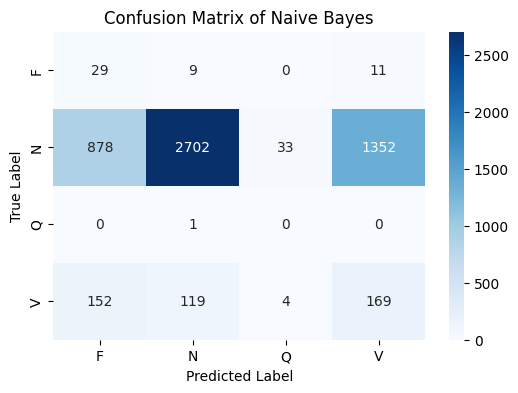

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix of Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
y_pred = svc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           F       0.06      0.57      0.10        49
           N       0.97      0.61      0.75      4965
           Q       0.00      0.00      0.00         1
           V       0.17      0.71      0.27       444

    accuracy                           0.62      5459
   macro avg       0.30      0.47      0.28      5459
weighted avg       0.90      0.62      0.70      5459



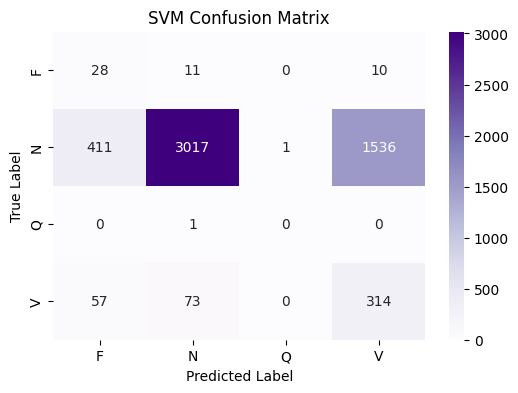

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Summary of this part:
1. The goal is to maximize both metrics Acc_T and Acc_A at the same time
1. naive Bayes performs rather poorly
> - problem with data imbalace
2. SVM has simillar problem, but after data balacing works quite good

-----------------------------------
balanced DT
Total accuracy, Acc_T = 0.7435
Arrhythmia accuracy, Acc_A = 0.3603
-----------------------------------
0.08133971291866028
0.023923444976076555
0.6555023923444976
0.291866028708134
0.4354066985645933
0.41148325358851673
0.5119617224880383
0.5645933014354066
0.5550239234449761
0.5550239234449761
0.5550239234449761
0.5119617224880383
0.47368421052631576
0.45454545454545453
0.44976076555023925
0.44019138755980863
0.44976076555023925
0.41626794258373206
0.4449760765550239
0.44019138755980863
0.4258373205741627
0.4019138755980861
0.41148325358851673
0.430622009569378
0.4019138755980861


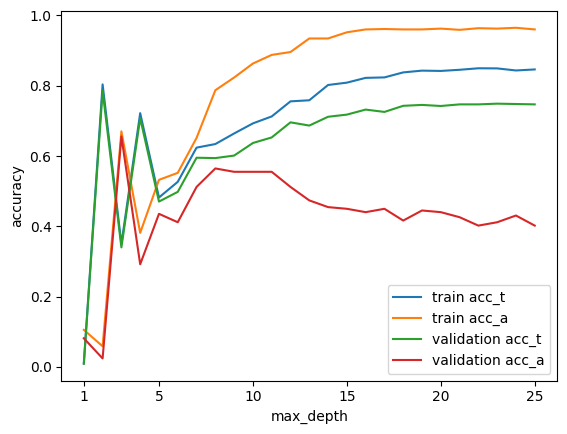

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='balanced DT')

# tunning max_dept hyperparameter (DT likes to overfit)
train_acc_t = []
train_acc_a = []
val_acc_t = []
val_acc_a = []
depth_range = range(1,26)
for max_depth in depth_range:
    dtc = DecisionTreeClassifier(criterion='entropy',
                                 class_weight='balanced',
                                 min_samples_leaf=10,
                                 max_depth=max_depth)
    dt_fit = dtc.fit(X_train, y_train)
    y_pred_train = dt_fit.predict(X_train)
    y_pred_val = dt_fit.predict(X_val)
    acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
    acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
    train_acc_t.append(acc_t_train)
    train_acc_a.append(acc_a_train)
    val_acc_t.append(acc_t_val)
    val_acc_a.append(acc_a_val)
    print(acc_a_val)

import matplotlib.pyplot as plt
_, ax = plt.subplots()
ax.plot(depth_range, train_acc_t, label='train acc_t')
ax.plot(depth_range, train_acc_a, label='train acc_a')
ax.plot(depth_range, val_acc_t, label='validation acc_t')
ax.plot(depth_range, val_acc_a , label='validation acc_a')
ax.set(xlabel='max_depth', ylabel='accuracy')
ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.legend()
plt.show()

In [ ]:
y_pred = dtc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           F       0.03      0.12      0.05        49
           N       0.93      0.78      0.85      4965
           Q       0.00      0.00      0.00         1
           V       0.16      0.39      0.22       444

    accuracy                           0.74      5459
   macro avg       0.28      0.32      0.28      5459
weighted avg       0.86      0.74      0.79      5459



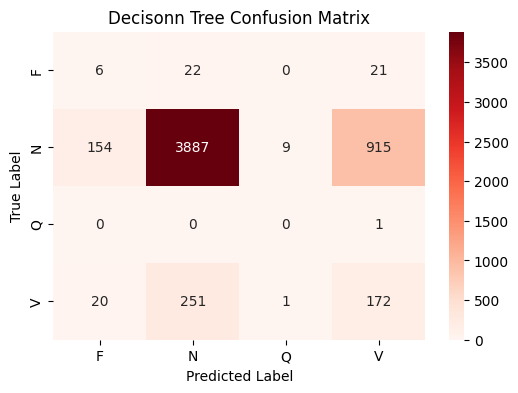

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=labels, yticklabels=labels)
plt.title("Decisonn Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# optimum acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=8)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
calculate_accuracy(y_pred, y_test, comment='DT: Acc_A maximized')

# optimum acc_t & acc_a max_depth
dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=13)
y_pred = dtc.fit(X_train, y_train).predict(X_test)
accuracy= calculate_accuracy(y_pred, y_test, comment='DT: Acc_T + Acc_A maximized')

# acc_t_train, acc_a_train = calculate_accuracy(y_pred_train, y_train, printout=False)
# acc_t_val, acc_a_val = calculate_accuracy(y_pred_val, y_val, printout=False)
# train_acc_t.append(acc_t_train)
# train_acc_a.append(acc_a_train)
# val_acc_t.append(acc_t_val)
# val_acc_a.append(acc_a_val)
# print(acc_a_val)

-----------------------------------
DT: Acc_A maximized
Total accuracy, Acc_T = 0.6001
Arrhythmia accuracy, Acc_A = 0.5709
-----------------------------------
-----------------------------------
DT: Acc_T + Acc_A maximized
Total accuracy, Acc_T = 0.6829
Arrhythmia accuracy, Acc_A = 0.4352
-----------------------------------


In [ ]:
y_pred = dtc.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           F       0.05      0.24      0.08        49
           N       0.94      0.71      0.81      4965
           Q       0.00      0.00      0.00         1
           V       0.14      0.46      0.22       444

    accuracy                           0.68      5459
   macro avg       0.28      0.35      0.28      5459
weighted avg       0.86      0.68      0.75      5459



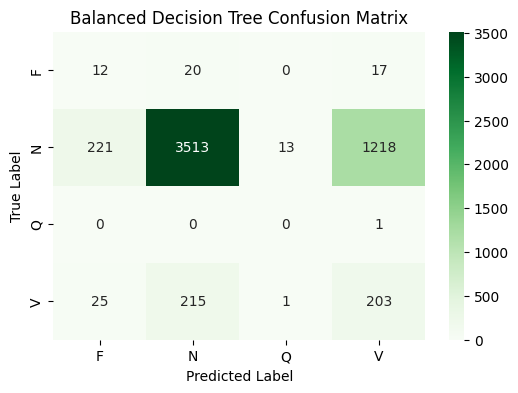

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Balanced Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# feature vector via PCA (dimensionlality reduction) works poorly
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
X_train_ = pca.fit_transform(X_train)
X_test_ = pca.fit_transform(X_test)

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=5,
                             max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with PCA')

-----------------------------------
DT with PCA
Total accuracy, Acc_T = 0.5809
Arrhythmia accuracy, Acc_A = 0.2874
-----------------------------------


Summary:
1. Decision Tree works a bit worse (than SVM) and has tendency to overfit. We consider two types of hyperparameters:
> - *max_depth*
> - *min_samples_leaf*
2. Tunning *max_depth* gives Acc_A (*max_depth*=8), or Acc_T & Acc_A (*max_depth*=13) maximum value
3. Simple dimensionality reduction using PCA works rather poorly

In [ ]:
import pywt

# extract features using different wavelets and simple differences
def extract_features(input_sample):
    out = np.array([])
# sym8
    cA = pywt.downcoef('a', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'sym8', level=4, mode='per')
    out = np.append(out,cD)
# db6/9
    cA = pywt.downcoef('a', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db6', level=4, mode='per')
    out = np.append(out,cD)
    cA = pywt.downcoef('a', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'db9', level=4, mode='per')
    out = np.append(out,cD)
# dmey
    cA = pywt.downcoef('a', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cA)
    cD = pywt.downcoef('d', input_sample, 'dmey', level=4, mode='per')
    out = np.append(out,cD)

# differences
    differences = np.zeros(16)
    for i, t in enumerate(range(40, 56)):
        differences[i] = input_sample[t+1]-input_sample[t]
    out = np.append(out,differences)
    return out

# collect vector of features for all samples
def data_features(input_data):
    return np.array([extract_features(sample) for sample in input_data])

X_train_ = data_features(X_train)
print(X_train_.shape)
X_test_ = data_features(X_test)
print(X_test_.shape)

dtc = DecisionTreeClassifier(criterion='entropy',
                             class_weight='balanced',
                             min_samples_leaf=10,
                             max_depth=8)
y_pred = dtc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='DT with wavelets')

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy',
                             n_estimators=1000,
                             max_depth=8,
                             class_weight='balanced')
y_pred = rfc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='RF with wavelets')

from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=200)
y_pred = abc.fit(X_train_, y_train).predict(X_test_)
calculate_accuracy(y_pred, y_test, comment='Ada with wavelets')

(9126, 64)
(5459, 64)
-----------------------------------
DT with wavelets
Total accuracy, Acc_T = 0.6030
Arrhythmia accuracy, Acc_A = 0.6255
-----------------------------------
-----------------------------------
RF with wavelets
Total accuracy, Acc_T = 0.7326
Arrhythmia accuracy, Acc_A = 0.5526
-----------------------------------
-----------------------------------
Ada with wavelets
Total accuracy, Acc_T = 0.8795
Arrhythmia accuracy, Acc_A = 0.0020
-----------------------------------


# Tasks to do
Please choose and complete just **one** of them:
1. Modify classifier to get **accuracy > 0.57** for both Acc_T *and* Acc_A
> - play with classifier hyperparameters
> - add some other features, e.g:
>> - [mean of absolute value (MAV) of signal](https://www.researchgate.net/publication/46147272_Sequential_algorithm_for_life_threatening_cardiac_pathologies_detection_based_on_mean_signal_strength_and_EMD_functions)
>> - signal energy/entropy
>> - some other signal features from [scipy signal](https://docs.scipy.org/doc/scipy/reference/signal.html#peak-finding),
>> - **in case of troubles:** distances between previous and next heartbeats are strong features, see e.g. [here](https://link.springer.com/article/10.1007/s11760-009-0136-1),
>> - it may be also usefull to perform some feature selection, e.g. choose these with variance higher than some assumed threshold (*intuition*: variance measures amount of information in a given feature), or use *model.feature_importances_* attribute (for more see [here](https://scikit-learn.org/stable/modules/feature_selection.html))
> - or build your own classifier (e.g. deep-neural-like)
2. Compare results for Random Forest with AdaBoost classifier
> - try to figure out why the default Ada setup won't work
> - and fix this problem (hint: resampling)
3. Add deep-neural classifier (like one in previous lab) and compare its preformance with today's best classifier
> - at first you should create *torch.utils.data.DataLoader* object, see [here](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)